In [3]:
# @title
# Instala a biblioteca pvlib
!pip install pvlib

In [4]:
# Monta o Google Drive para acessar arquivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Secao do Desing do Sistema

In [5]:
# @title
# Trabalho 1 - Simulação de UFV com PvLib e PvSist

# Integrantes do Grupo:
# Christian Brandemarte  RA 272951
# Larissa Souza          RA 216432
# Matheus Vechini        RA 271362


# O objetivo do trabalho será simular uma Usina fotovoltáica real localizada em Pirangi, SP.
# A Usina em questão foi a causadora de uma elevação de tensão em alimentadores da distribuidora local.
# A simulação irá complementar o artigo de final do curso, onde iremos apresentar o estudo de caso em que houve impacto na qualidade de fornecimento de energia na distribuição.


# Configuração Geral:
# o clearsky_model: ineichen
# o transposition_model: Perez
# o solar_position_method: nrel_numpy
# o airmass_model: kastenyoung1989 (utilizada através do modelo Perez)
# o dc_model: cec
# o ac_model: sandia_inverter
# o aoi_model: no_aoi_loss
# o spectral_model: no_spectral_loss
# o temperature_model: sapm_temp, pvsyst
# o losses_model: no_extra_losses


# 1- Modelagem da Usina Fotovoltaica

# Declaração da potência em (Kw) da UFV.
P_Total= 1000

# Importa as bibliotecas necessárias
from pvlib.pvsystem import retrieve_sam
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.location import Location
import pvlib

# Seleção dos compoentes

# Carrega e transpõe o banco de dados para formato de lista
module_db = retrieve_sam('cecmod')
modules_df = module_db.T  # Transpõe o DataFrame

# Calcula a potência de pico (Pmpp) manualmente de cada módulo presente na biblioteca
modules_df['Pmpp'] = modules_df['V_mp_ref'] * modules_df['I_mp_ref']

# Ordena os módulos de acordo com a potência em modo decrescente
top_modules = modules_df.sort_values('Pmpp', ascending=False)

# Exibe os 10 módulos mais potentes da bilbioteca do Pvlib para ser escolhido
print("Top 10 módulos mais potentes da biblioteca CEC:")
print(top_modules[['Pmpp', 'V_mp_ref', 'I_mp_ref', 'V_oc_ref', 'I_sc_ref']].head(10))

# Exibe informações adicionais dos top 10 módulos (opcional)
# print("\nDetalhes completos dos top 10 módulos:")
# print(top_modules.head(10))

# Exibe a lista de colunas disponíveis no DataFrame de módulos
# print("\nColunas disponíveis no DataFrame de módulos:")
# print(top_modules.columns.tolist())

Top 10 módulos mais potentes da biblioteca CEC:
                                Pmpp V_mp_ref I_mp_ref V_oc_ref I_sc_ref
Sunpreme_Inc__SNPM_GxB_510    509.97     57.3      8.9     74.7      9.4
Miasole_FLEX_03_500W           499.8     60.0     8.33     74.8      9.4
Sunpreme_Inc__SNPM_GxB_500    499.38     57.4      8.7     72.9      9.2
Sunpreme_Inc__SNPM_GxB_490    489.81     56.3      8.7     71.8      9.2
Miasole_FLEX_03_490W         489.685     59.5     8.23     74.5      9.4
Sunpower_SPR_X22_480_COM      480.32     79.0     6.08     92.9     6.48
Miasole_FLEX_03_480W          479.67     59.0     8.13     74.2      9.4
Heliene_96M475              477.3902    52.06     9.17    62.39     9.84
SunPower_SPR_X22_475_COM     476.495     78.5     6.07     92.5     6.45
Heliene_96M470              472.4446    51.86     9.11    62.19     9.76


In [6]:
# Seleciona o módulo para utilizar as características técnicas nos calculos.
module = module_db['Sunpower_SPR_X22_480_COM']
pmpp = modules_df.loc['Sunpower_SPR_X22_480_COM', 'Pmpp']
# Foi escolhido este módulo pois é o painel monocristalino de maior potência na biblioteca do PVlib.
# O módulo real utilizado na UFV é de 545W da Longi Solar, no entanto, o enunciado do trabalho informa para utilizar equipamentos presentes na biblioteca PvLib


# Calcula a quantidade de módulos necessária, considerando 20% de oversizing
n_modulos = (P_Total * 1.20 * 1000) / pmpp
n_modulos = int(n_modulos) + 1 # arredonda o calculo para cima

# Exibe a quantidade de módulos e as característica do modelo escolhido
print(f"Será necessário {n_modulos} módulos do modelo Sunpower_SPR_X22_480_COM, já considerando 20 porcento de oversizing\n")
print("Dados do módulo Sunpower_SPR_X22_480_COM:\n",
      modules_df.loc['Sunpower_SPR_X22_480_COM', ['Pmpp', 'V_mp_ref', 'V_oc_ref', 'I_mp_ref', 'I_sc_ref']])

Será necessário 2499 módulos do modelo Sunpower_SPR_X22_480_COM, já considerando 20 porcento de oversizing

Dados do módulo Sunpower_SPR_X22_480_COM:
 Pmpp        480.32
V_mp_ref      79.0
V_oc_ref      92.9
I_mp_ref      6.08
I_sc_ref      6.48
Name: Sunpower_SPR_X22_480_COM, dtype: object


In [7]:
# Considerando a quantidade de módulos que será implementada, e a potência total da UFV (1000KW) será utilizado um inversor de exatamente 1000KW disponível na biblioteca

# Carrega e transpõe o banco de dados dos inversores
inverter_db = retrieve_sam('cecinverter')
inverter_df = inverter_db.T

# Filtra os inversores com Paco (Potência nominal de saída em corrente alternada) <= 1M W
filtered_inverters = inverter_df[inverter_df['Paco'] <= 1000000]

# Ordena do maior para o menor pela potência nominal de saída (Paco)
filtered_inverters = filtered_inverters.sort_values('Paco', ascending=False)

# Exibe os 10 inversores com maior Paco
print("Top 10 inversores com maior Paco (Potência AC de saída):")
print(filtered_inverters[['Paco', 'Vac', 'Pso', 'Pdco', 'Vdco']].head(10))

Top 10 inversores com maior Paco (Potência AC de saída):
                                                         Paco  Vac  \
Perfect_Galaxy__EPP_1000_0600_32060_200X_U_P        1000000.0    0   
Satcon_Technology__EPP_1000_0600_32060_200X_U_N     1000000.0    0   
Perfect_Galaxy__EQX1000UV400XP_N_                   1000000.0    0   
American_Electric_Technologies__ISIS_1000_15000_60  1000000.0    0   
American_Electric_Technologies__ISIS_1000_410_60    1000000.0    0   
Destin_Power_Inc___SAVEEN1000_ES02H_US__440V_       1000000.0  440   
Perfect_Galaxy__EPP_1000_0600_32060_200X_U_N        1000000.0    0   
Satcon_Technology__PVS_1000                         1000000.0    0   
ABB__ULTRA_1100_TL_OUTD_4_US_690_x_y_z__690V_       1000000.0  690   
ABB__ULTRA_1100_TL_OUTD_2_US_690_x_y_z__690V_       1000000.0  690   

                                                            Pso          Pdco  \
Perfect_Galaxy__EPP_1000_0600_32060_200X_U_P         4738.73877  1045042.1875   
Satcon_Tec

In [8]:
# Exibe o inversor escolhido e as características técnicas do datasheet PvLib
# O inversor ABB__ULTRA_1100_TL_OUTD_4_US_690_x_y_z__690V_ foi escolhido por ter Paco próximo a 1000kW
print("Será utilizado o inversor modelo ABB__ULTRA_1100_TL_OUTD_4_US_690_x_y_z__690V_\n")
print("Dados do inversor ABB__ULTRA_1100_TL_OUTD_4_US_690_x_y_z__690V_\n",
      inverter_df.loc['ABB__ULTRA_1100_TL_OUTD_4_US_690_x_y_z__690V_', ['Paco', 'Vac', 'Pso', 'Pdco', 'Vdco']])

Será utilizado o inversor modelo ABB__ULTRA_1100_TL_OUTD_4_US_690_x_y_z__690V_

Dados do inversor ABB__ULTRA_1100_TL_OUTD_4_US_690_x_y_z__690V_
 Paco      1000000.0
Vac             690
Pso      4451.37207
Pdco    1036900.125
Vdco          746.0
Name: ABB__ULTRA_1100_TL_OUTD_4_US_690_x_y_z__690V_, dtype: object


In [9]:
# @title
# Importa e converte os valores do csv de irradiância baixado do NSRDB. Removido as 2 primeiras linhas manualmente antes)
# Assume-se que o arquivo CSV contém dados meteorológicos horários ou sub-horários.
csv_path = r"/content/drive/MyDrive/Colab Notebooks/Trabalho I - Modelagem UFV (Chirstian B_Larissa S_Matheus V)/dados_meteorolขgicos_NSRDB_Pirangi_SP(3).csv"

df = pd.read_csv(csv_path)

# Cria coluna de timestamp e define como índice
df['timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df = df.set_index('timestamp')

# Seleciona e reordena as colunas desejadas
colunas_desejadas = ['GHI', 'DNI', 'DHI', 'Temperature', 'Wind Speed']

# Cria novo DataFrame com timestamp como coluna (em formato string) para exibição
df_formatado = df[colunas_desejadas].copy()
df_formatado.insert(0, 'DataHora', df_formatado.index.strftime('%d/%m/%Y %H:%M:%S'))

# Exibe as primeiras linhas do DataFrame formatado
print("Primeiras linhas do DataFrame formatado:")
print(df_formatado.head())

# Exibe estatísticas descritivas do DataFrame formatado
print("\nEstatísticas descritivas do DataFrame formatado:")
print(df_formatado.describe())

Primeiras linhas do DataFrame formatado:
                                DataHora  GHI  DNI  DHI  Temperature  \
timestamp                                                              
2023-01-01 00:00:00  01/01/2023 00:00:00    0    0    0         24.7   
2023-01-01 00:30:00  01/01/2023 00:30:00    0    0    0         24.4   
2023-01-01 01:00:00  01/01/2023 01:00:00    0    0    0         24.2   
2023-01-01 01:30:00  01/01/2023 01:30:00    0    0    0         23.7   
2023-01-01 02:00:00  01/01/2023 02:00:00    0    0    0         23.2   

                     Wind Speed  
timestamp                        
2023-01-01 00:00:00         0.4  
2023-01-01 00:30:00         0.4  
2023-01-01 01:00:00         0.4  
2023-01-01 01:30:00         0.5  
2023-01-01 02:00:00         0.6  

Estatísticas descritivas do DataFrame formatado:
                GHI           DNI           DHI   Temperature    Wind Speed
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000
mean     230.9

# Sobre a Localidade

In [10]:
# Define a localização da UFV em Pirangi
latitude = -21.095481
longitude = -48.664791
site = Location(latitude, longitude, tz='Etc/GMT+3', altitude=542, name='Pirangi/SP')

# Calcula a posição do sol para cada momento do ano presente no arquivo csv (Ano de 2023)
# Utiliza o método 'nrel_numpy' para o cálculo da posição solar
solar_position = site.get_solarposition(df_formatado.index, method='nrel_numpy')

# Calcula a irradiância extraterrestre (irradiância no topo da atmosfera)
dni_extra = pvlib.irradiance.get_extra_radiation(df_formatado.index)

# Exibe as primeiras linhas do DataFrame de posição solar
print("Primeiras linhas do DataFrame de Posição Solar:")
print(solar_position.head())

# Exibe as primeiras linhas da série de irradiância extraterrestre
print("\nPrimeiras linhas da série de Irradiância Extraterrestre:")
print(dni_extra.head())

Primeiras linhas do DataFrame de Posição Solar:
                     apparent_zenith      zenith  apparent_elevation  \
timestamp                                                              
2023-01-01 00:00:00       114.657376  114.657376          -24.657376   
2023-01-01 00:30:00       119.839595  119.839595          -29.839595   
2023-01-01 01:00:00       124.544202  124.544202          -34.544202   
2023-01-01 01:30:00       128.638775  128.638775          -38.638775   
2023-01-01 02:00:00       131.966203  131.966203          -41.966203   

                     elevation     azimuth  equation_of_time  
timestamp                                                     
2023-01-01 00:00:00 -24.657376  230.310063         -3.187402  
2023-01-01 00:30:00 -29.839595  225.184517         -3.197268  
2023-01-01 01:00:00 -34.544202  219.217839         -3.207132  
2023-01-01 01:30:00 -38.638775  212.297253         -3.216993  
2023-01-01 02:00:00 -41.966203  204.366833         -3.226852  

Prime

# Seção objetivo 1: Estimativa da Irradiância no plano dos módulos

## A descricao do modelo de cálculo da irradiância no plano dos módulos (POA)

o Será necessária a geração de dados atmosféricos para a estimativa de POA (Pode considerar os modelos padrão do pvlib);
o Mostrar a curva de otimização de ganho de transposição ao longo da variação do ângulo de inclinação;
o Definir e descrever brevemente o modelo físico para estimar o Modificador do Ângulo de Incidência (IAM); (POA)**

#### **Modelo Adotado para o Cálculo da POA**
A estimativa da irradiância no plano dos módulos (POA, *Plane of Array*) foi realizada seguindo uma abordagem que considera os componentes direto, difuso e refletido da irradiância solar. O modelo adotado inclui as seguintes etapas:

1. **Cálculo da Posição Solar:**
   - Foram determinados os ângulos zenital e azimutal do Sol para cada instante de tempo, utilizando as coordenadas geográficas do local.

2. **Cálculo do Ângulo de Incidência (AOI):**
   - O ângulo de incidência (AOI, *Angle of Incidence*) entre os raios solares e a superfície dos módulos foi calculado com base na inclinação dos módulos (beta°) e sua orientação (180° = Sul). Esse ângulo é crítico para determinar as perdas por reflexão.

3. **Correção da Irradiância Direta Normal (DNI):**
   - A DNI foi ajustada aplicando um fator de perda devido ao ângulo de incidência (`iam`), calculado usando o modelo físico (`physical`). Isso garante que apenas a irradiância efetivamente incidente nos módulos seja considerada.

4. **Cálculo da Massa de Ar e Pressão Atmosférica:**
   - A massa de ar relativa e absoluta foi calculada para corrigir a atenuação da irradiância solar pela atmosfera, considerando a altitude do local.

5. **Transposição da Irradiância para o Plano dos Módulos:**
   - A irradiância total no plano dos módulos (POA) foi calculada utilizando a função `get_total_irradiance` do PVlib, que combina os componentes:
     - **Direto (DNI corrigido):** Projetado no plano dos módulos.
     - **Difuso (DHI):** Modelado como isotrópico, assumindo distribuição uniforme no céu.
     - **Refletido (albedo):** Considerou-se um albedo para a refletividade do solo em %.

6. **Modelo de Transposição:**
   - O modelo isotrópico foi utilizado para a componente difusa, enquanto o modelo de Perez (`allsitescomposite1990`) foi aplicado para melhorar a precisão em condições de céu parcialmente nublado.



### **Resultados e Análise**
- **Métricas Comparativas:**
  - **POA Máxima:** 1115.08 W/m²  
  - **POA Média:** 212.70 W/m²  
  - **Energia Total Anual:** 1858.12 kWh/m²  
  - **Comparação com a GHI (Irradiância Global Horizontal)**:
    - A POA apresentou valores máximos superiores à GHI (1115.08 W/m² vs. 1083.00 W/m²), demonstrando o ganho proporcionado pela inclinação dos módulos.
    - A energia total anual foi ligeiramente menor na POA (1858.12 kWh/m² vs. 1975.26 kWh/m² da GHI), refletindo as perdas por ângulo de incidência e a sazonalidade da irradiação.

- **Variação Diária da Razão POA/GHI:**
  - O gráfico da razão POA/GHI apresenta variação sazonal entre 0,7 e 1,3. Nos equinócios (março/setembro), a inclinação de 20° maximiza a captação (razão>1), enquanto nos solstícios (junho/dezembro) ocorrem perdas por ângulo de incidência (razão<1). A configuração fixa mostra-se ineficiente para todo o ano nesta localização equatorial. Fatores como posição solar variável e alta irradiação difusa na região andina explicam estas flutuações.



## Ferramentas de Cálculo do POA

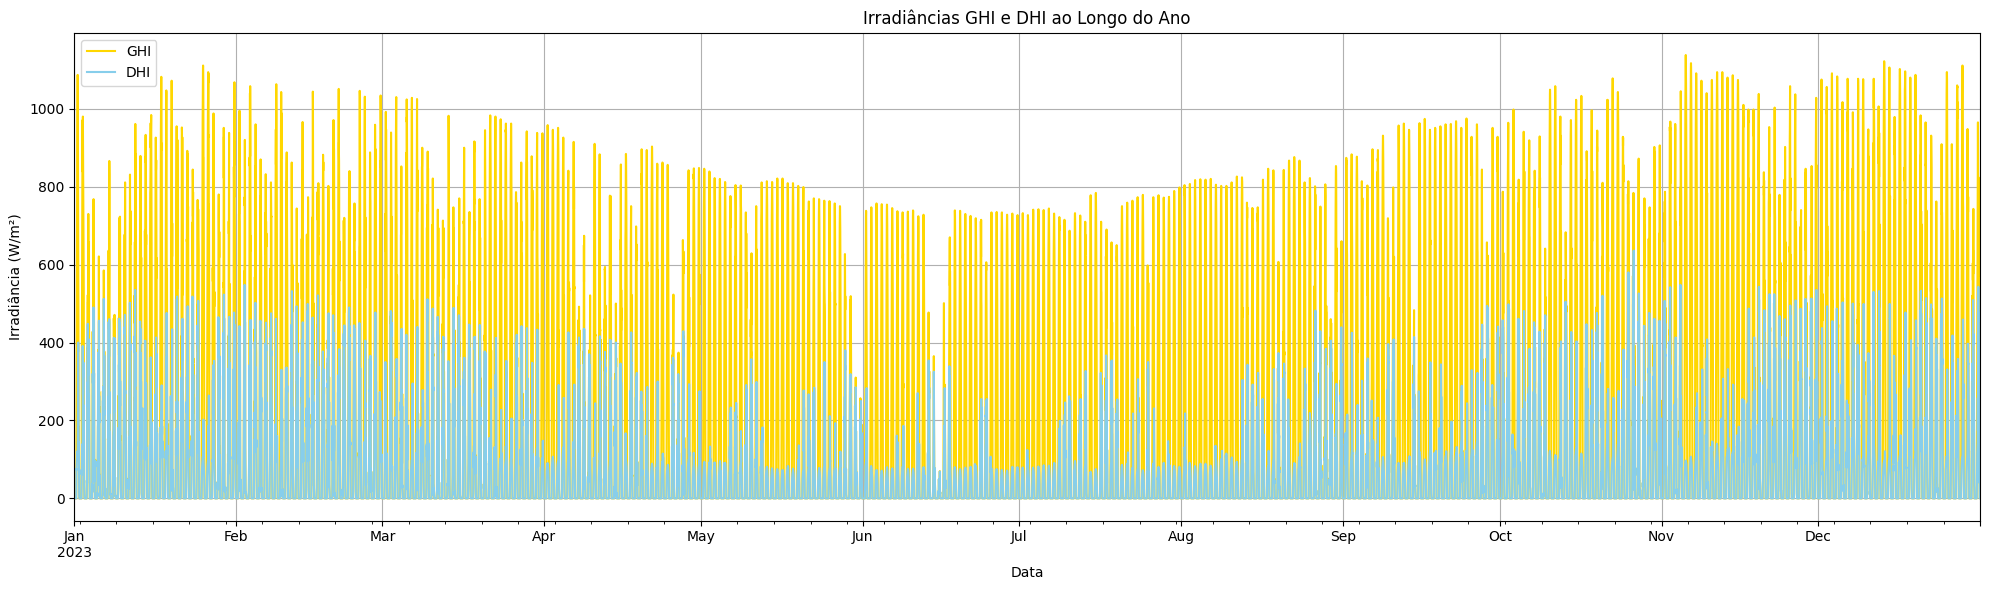

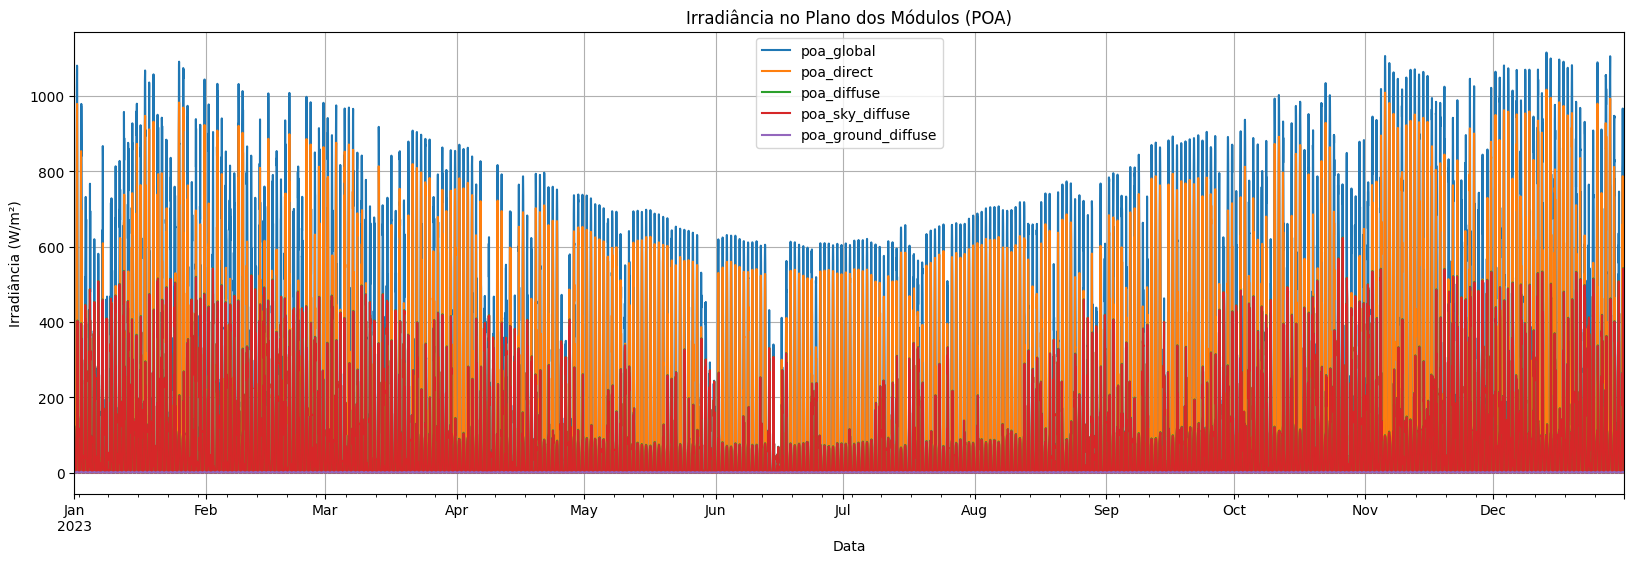

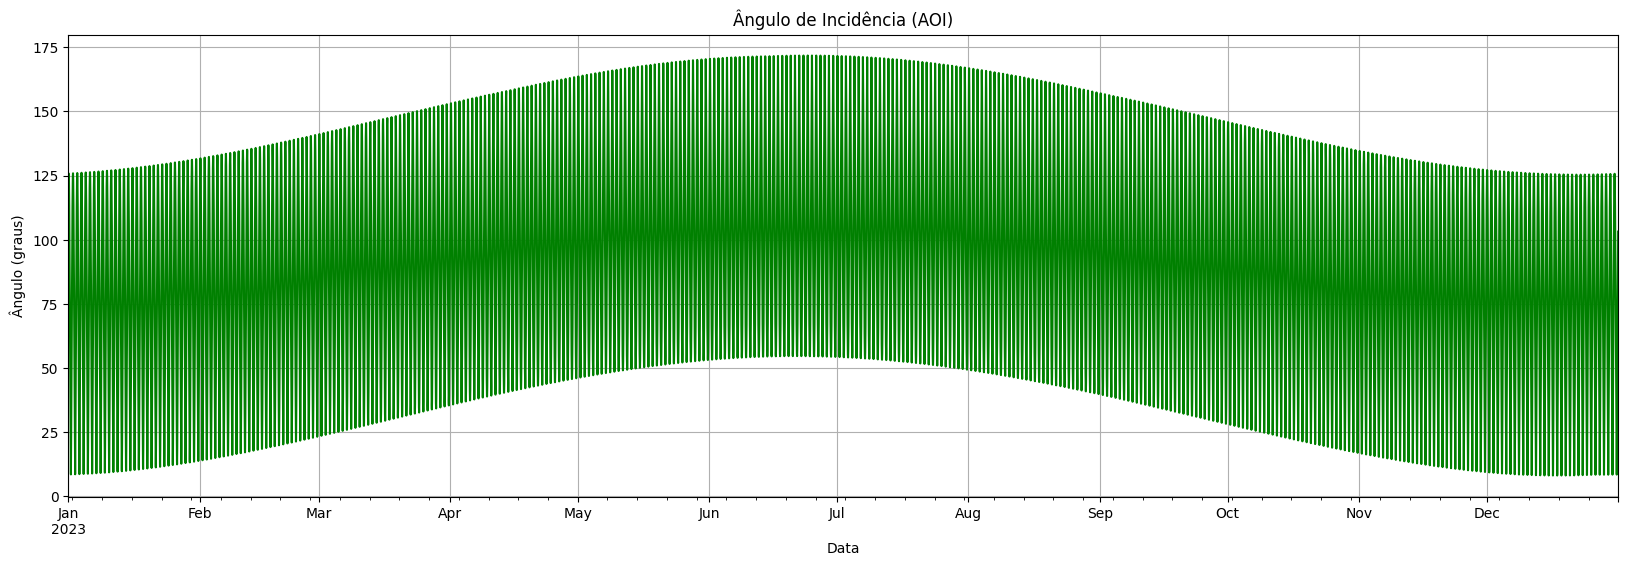

In [11]:
# @title
# Cálculo do POA - Irradiância no plano dos módulos, Modelo Perez

# Define a inclinação (tilt) e o azimute (azimuth) da superfície dos módulos
surface_tilt=10 # Inclinação dos módulos em graus (0 para horizontal, 90 para vertical)
surface_azimuth=180 # Apontado para o Sul (180 graus)

# Calcula a irradiância total no plano dos módulos (POA)
poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt,        # Inclinação da superfície
    surface_azimuth,     # Azimute da superfície
    dni=df['DNI'],       # Irradiância Direta Normal (do CSV)
    ghi=df['GHI'],       # Irradiância Global Horizontal (do CSV)
    dhi=df['DHI'],       # Irradiância Difusa Horizontal (do CSV)
    dni_extra=dni_extra, # Irradiância Extraterrestre Normal (calculada)
    solar_zenith=solar_position['zenith'], # Ângulo zenital do sol (calculado)
    solar_azimuth=solar_position['azimuth'], # Ângulo azimutal do sol (calculado)
    model='perez'        # Adotado o modelo Perez, pois é mais preciso que o haydavies, no entanto, mais pesado para processamento
)

# Calcula o ângulo de incidência (AOI) entre os raios solares e a superfície dos módulos
aoi = pvlib.irradiance.aoi(surface_tilt=surface_tilt,
                           surface_azimuth=surface_azimuth,
                           solar_zenith=solar_position['zenith'],
                           solar_azimuth=solar_position['azimuth'])

# --- Visualização dos Dados ---

# Plota os valores de GHI e DHI ao longo do ano
plt.figure(figsize=(20, 6))
df_formatado['GHI'].plot(label='GHI', color='gold')
df_formatado['DHI'].plot(label='DHI', color='skyblue')
plt.title('Irradiâncias GHI e DHI ao Longo do Ano')
plt.xlabel('Data')
plt.ylabel('Irradiância (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico da irradiância no plano dos módulos (POA) ao longo do ano
poa.plot(figsize=(20, 6))
plt.title('Irradiância no Plano dos Módulos (POA)')
plt.xlabel('Data')
plt.ylabel('Irradiância (W/m²)')
plt.grid(True)
plt.show()

# Gráfico do ângulo de incidência (AOI) ao longo do ano
plt.figure(figsize=(20, 6))
aoi.plot(color='green')
plt.title('Ângulo de Incidência (AOI)')
plt.xlabel('Data')
plt.ylabel('Ângulo (graus)')
plt.grid(True)
plt.show()

In [12]:
# Seção de Análise 2: Cálculo da Potência DC e Energia Mensal (Modelo Single Diode)

from pvlib.pvsystem import calcparams_cec, singlediode

# Parâmetros ambientais - Extrai os valores de Temperatura e velocidade do vento a partir do CSV do NSRDB
temps = df_formatado['Temperature'] # Temperatura ambiente em °C
winds = df_formatado['Wind Speed'] # Velocidade do vento em m/s

# Extrai os parâmetros do modulo através da biblioteca do PvLib para o módulo selecionado
module_params = modules_df.loc['Sunpower_SPR_X22_480_COM']

# Calcula parâmetros do SDM (Single Diode Model) usando o MODELO CEC
# O modelo CEC (California Energy Commission) é um modelo de um diodo usado para simular módulos PV.
IL, I0, Rs, Rsh, nNsVth = calcparams_cec(
    poa['poa_global'],  # Irradiância no plano dos módulos (W/m²)
    temps,              # Temperatura ambiente (°C)
    module_params['alpha_sc'], # Coeficiente de temperatura da corrente de curto-circuito (1/°C)
    module_params['a_ref'], # Parâmetro ideal do diodo em condição padrão (unitless)
    module_params['I_L_ref'], # Corrente foto-gerada (IL) em STC (A)
    module_params['I_o_ref'], # Corrente de saturação do diodo em STC (A)
    module_params['R_sh_ref'], # Resistência de shunt em STC (Ohm)
    module_params['R_s'], # Resistência série em STC (Ohm)
    module_params['Adjust'] # Fator de ajuste para corrigir pequenas divergências entre modelo e medição real
)

print("Foi utilizado o método CEC e a função de Lambert W na simulação do SDM.")
print(f"Valor de Resistência Série (Rs): {module_params['R_s']:.4f} Ohm")
print(f"Valor de Resistência de Shunt (Rsh): {module_params['R_sh_ref']:.4f} Ohm")

# Resolve a equação do diodo único utilizando a função de Lambert W.
# Este método é robusto para encontrar o ponto de máxima potência (MPP).
sdm_out = singlediode(IL, I0, Rs, Rsh, nNsVth, method='lambertw')

# Exibe as primeiras linhas do DataFrame de saída do modelo de diodo único
print("\nPrimeiras linhas da saída do Modelo de Diodo Único:")
print(sdm_out.head())

# Plota as curvas I-V (Corrente-Tensão) e P-V (Potência-Tensão) resultantes do modelo SDM
# sdm_out[['i_mp', 'v_mp', 'p_mp']].plot(figsize=(20, 6)) # Exemplo de plotagem, pode ser ajustado
# plt.title('Características Elétricas do Módulo (MPP)')
# plt.xlabel('Tensão (V)')
# plt.ylabel('Corrente (A) / Potência (W)')
# plt.grid(True)
# plt.show()

Foi utilizado o método CEC e a função de Lambert W na simulação do SDM.
Valor de Resistência Série (Rs): 0.4843 Ohm
Valor de Resistência de Shunt (Rsh): 619.8768 Ohm

Primeiras linhas da saída do Modelo de Diodo Único:
                     i_sc  v_oc  i_mp  v_mp  p_mp  i_x  i_xx
timestamp                                                   
2023-01-01 00:00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2023-01-01 00:30:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2023-01-01 01:00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2023-01-01 01:30:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2023-01-01 02:00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0


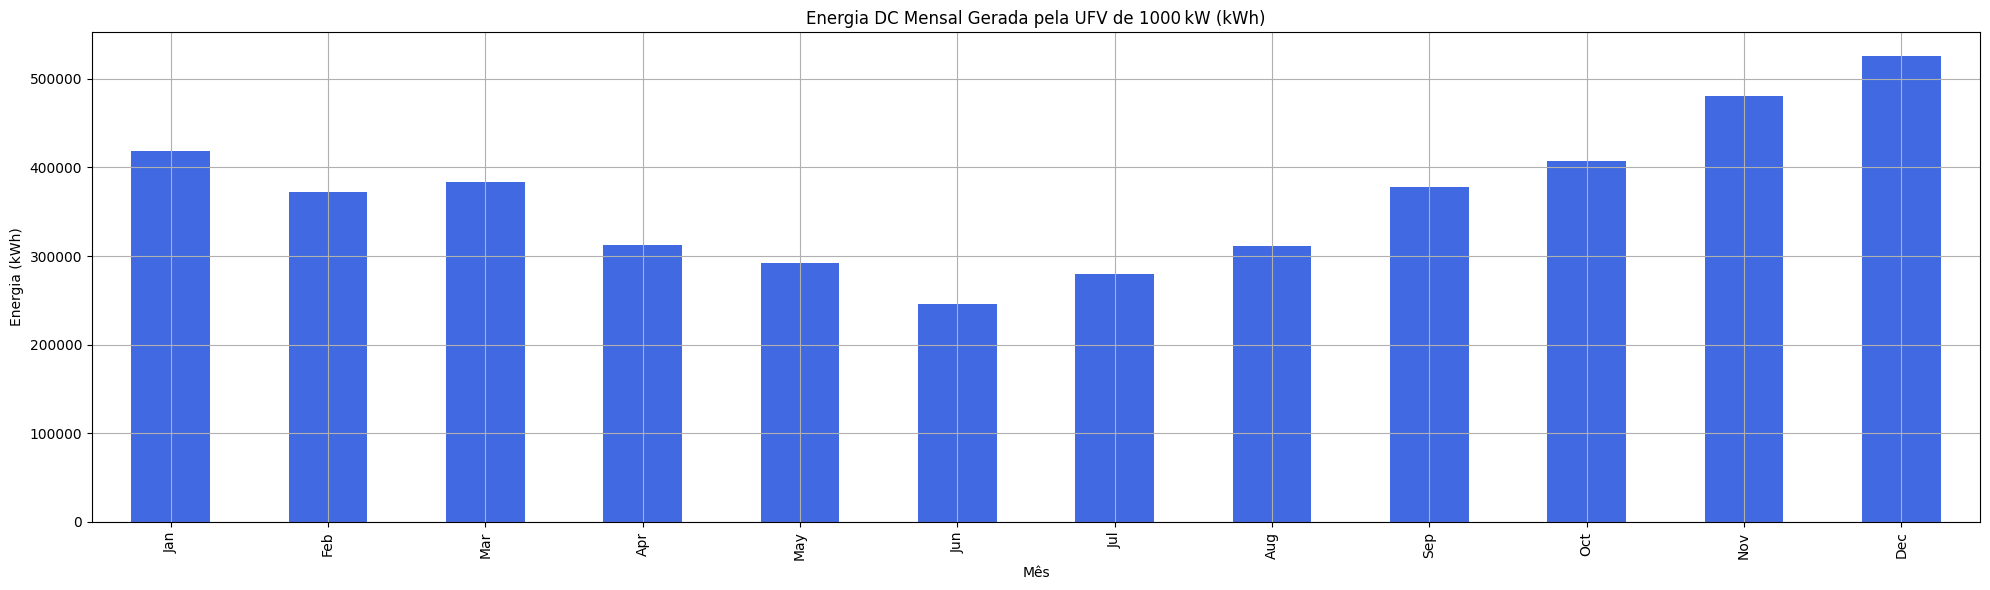

In [13]:
# Cálculo da potência DC total e energia mensal

# Potência DC gerada por um único módulo em cada instante de tempo no ponto de máxima potência (MPPT)
p_dc = sdm_out['p_mp']

# Calcula a potência DC total da UFV multiplicando pela quantidade total de módulos
p_dc_total = p_dc * n_modulos

# Calcula a energia mensal DC total (em kWh) somando a potência horária/minutal e convertendo para kWh
energia_dc_mensal = p_dc_total.resample('ME').sum() / 1000 # 'ME' significa Month End

# Formata os meses para exibição no eixo X do gráfico
energia_dc_mensal.index = energia_dc_mensal.index.strftime('%b') # %b exibe o nome abreviado do mês

# Gera o gráfico de barras da Energia DC Mensal
energia_dc_mensal.plot(kind='bar',
                       title='Energia DC Mensal Gerada pela UFV de 1000 kW (kWh)',
                       ylabel='Energia (kWh)',
                       xlabel='Mês',
                       figsize=(20, 6),
                       legend=False,
                       color='royalblue',
                       grid=True
                       )
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

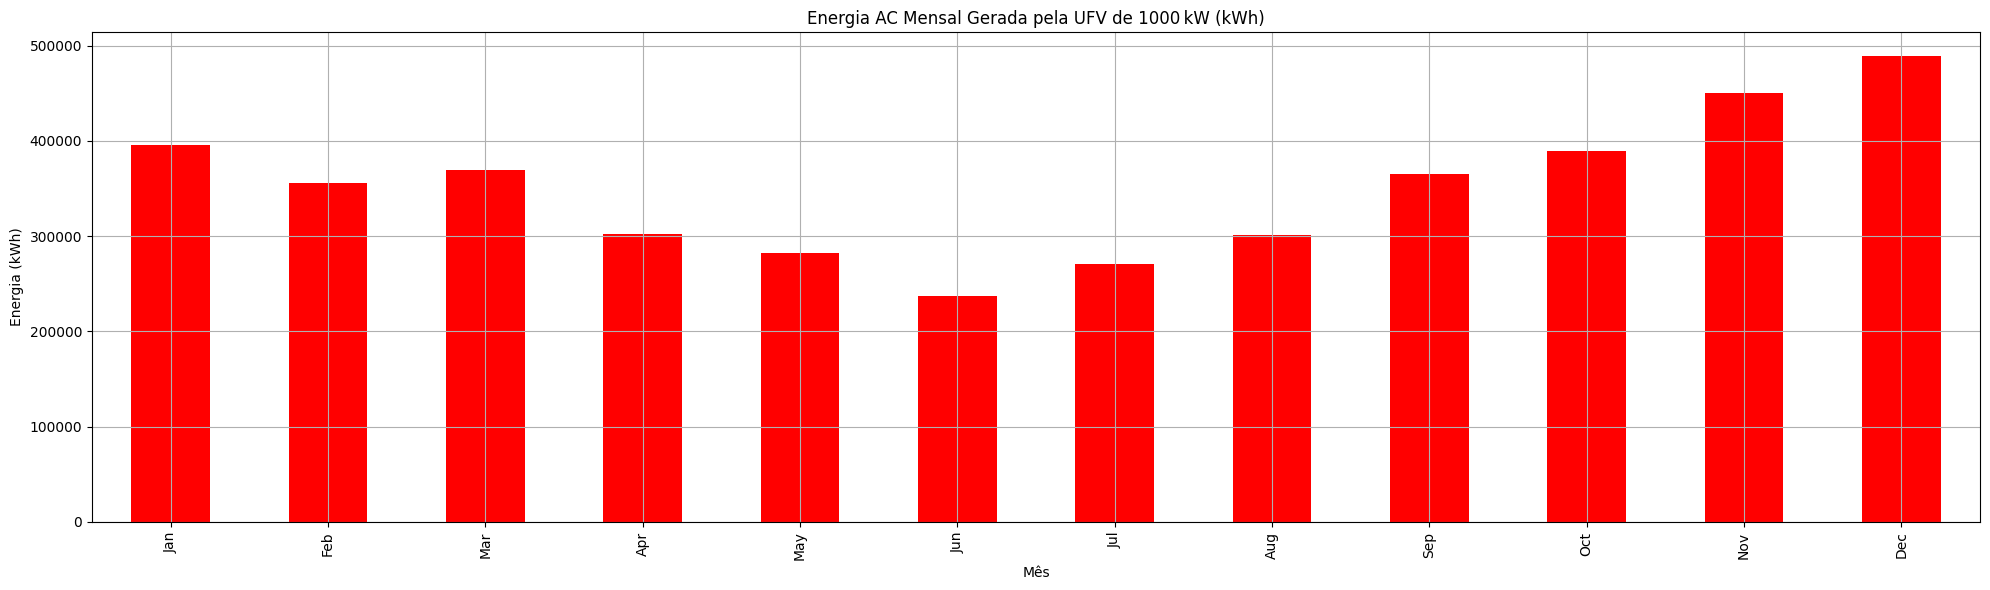

In [14]:
# Seção de Análise 3: Cálculo da Potência AC e Energia Mensal (Modelo Sandia)

from pvlib.inverter import sandia

# Extrai os parâmetros do inversor selecionado na biblioteca do PvLib
inverter = inverter_df.loc['ABB__ULTRA_1100_TL_OUTD_4_US_690_x_y_z__690V_']

# Define a tensão DC de operação do inversor (usando o valor nominal do datasheet do inversor)
# Em uma simulação mais detalhada, a tensão DC de entrada no inversor seria calculada com base na configuração das strings e na potência DC do gerador.
v_dc = inverter['Vdco']

# Cálculo da potência AC de saída do inversor usando o modelo Sandia
# O modelo Sandia de inversor simula a eficiência do inversor em diferentes condições de potência DC e tensão DC.
pac = sandia(v_dc=v_dc, # Tensão DC de entrada no inversor
             p_dc=p_dc_total, # Potência DC total gerada pelos módulos
             inverter=inverter) # Parâmetros do inversor

# A potência AC total já foi calculada no passo anterior (pac) pois p_dc_total foi usado como entrada
pac_total = pac

# Calcula a energia mensal AC total (em kWh)
energia_ac_mensal = pac_total.resample('ME').sum() / 1000 # 'ME' significa Month End

# Formata os meses para exibição no eixo X do gráfico
energia_ac_mensal.index = energia_ac_mensal.index.strftime('%b') # %b exibe o nome abreviado do mês

# Plota o gráfico de barras da Energia AC Mensal gerada pela UFV
energia_ac_mensal.plot(kind='bar',
                       title='Energia AC Mensal Gerada pela UFV de 1000 kW (kWh)',
                       ylabel='Energia (kWh)',
                       xlabel='Mês',
                       figsize=(20, 6),
                       color='red', # Cor vermelha para a energia AC
                       legend=False,
                       grid=True)
plt.tight_layout() # Ajusta o layout
plt.show()

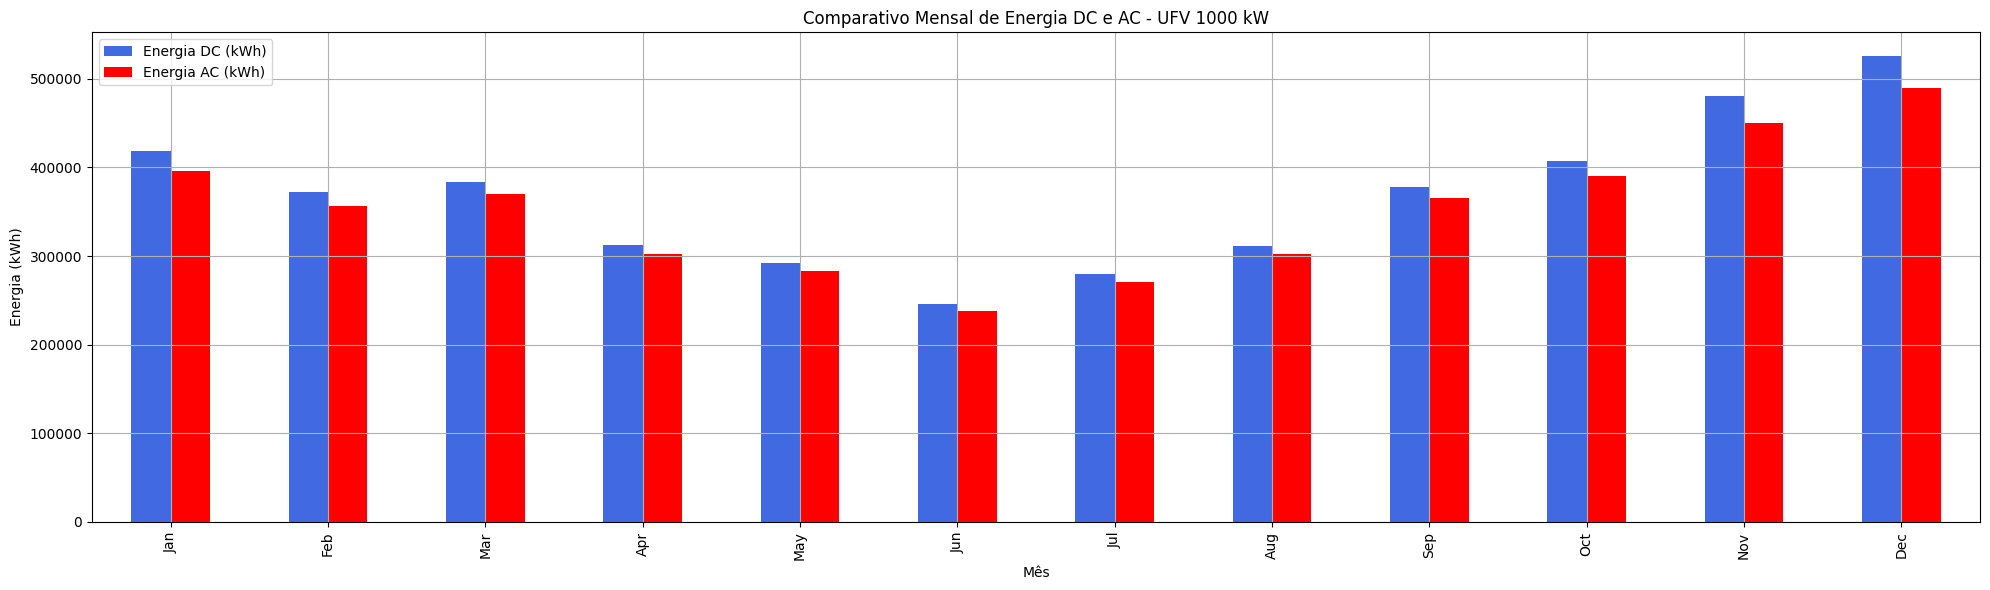

In [15]:
# Seção de Análise 4: Comparativo de Geração DC vs AC

# Plota um novo gráfico juntando as energias DC e AC mensais para comparação.
# Como pode ser observado, a potência AC é um pouco menor devido as perdas de conversão no inversor.
energia_comparativa = pd.concat([energia_dc_mensal, energia_ac_mensal], axis=1) # Concatena as séries em um DataFrame
energia_comparativa.columns = ['Energia DC (kWh)', 'Energia AC (kWh)'] # Renomeia as colunas

# Gera o gráfico de barras comparativo
energia_comparativa.plot(kind='bar',
                         figsize=(20, 6),
                         title='Comparativo Mensal de Energia DC e AC - UFV 1000 kW',
                         xlabel='Mês',
                         ylabel='Energia (kWh)',
                         color=['royalblue', 'red'], # Cores para as barras DC e AC
                         grid=True)

plt.legend() # Mostra a legenda identificando as barras DC e AC
plt.tight_layout() # Ajusta o layout
plt.show()

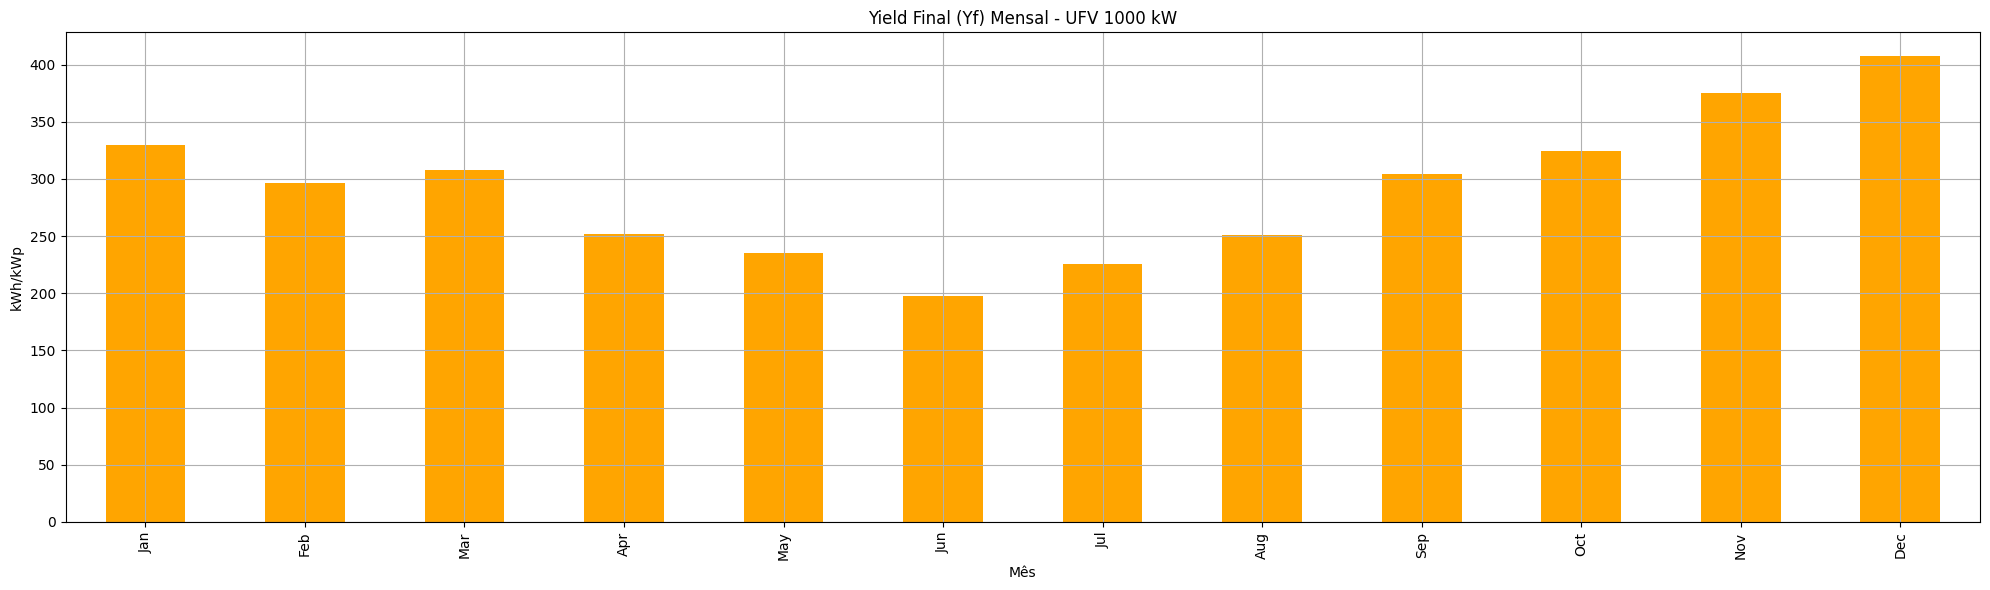

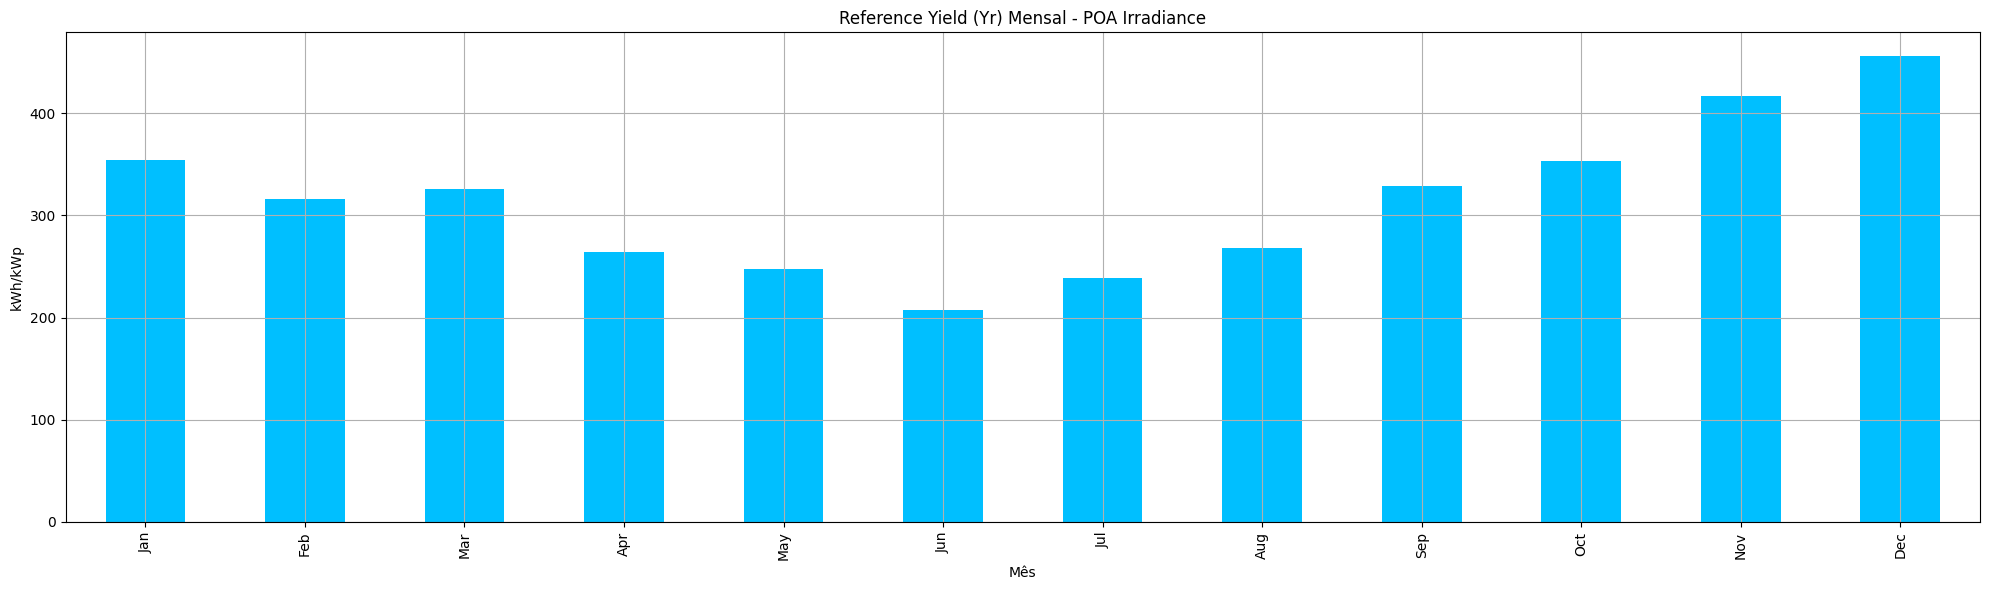

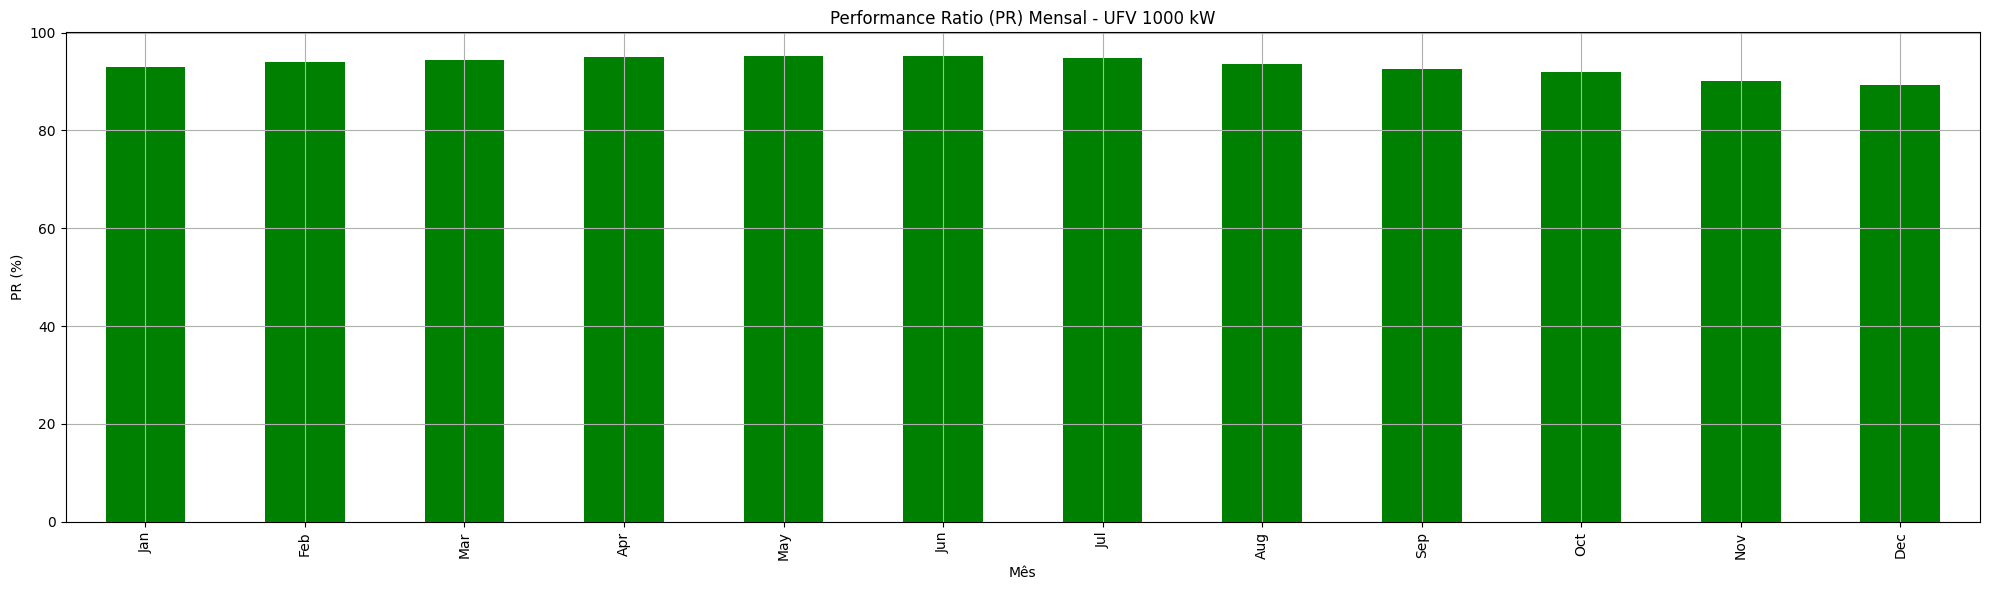

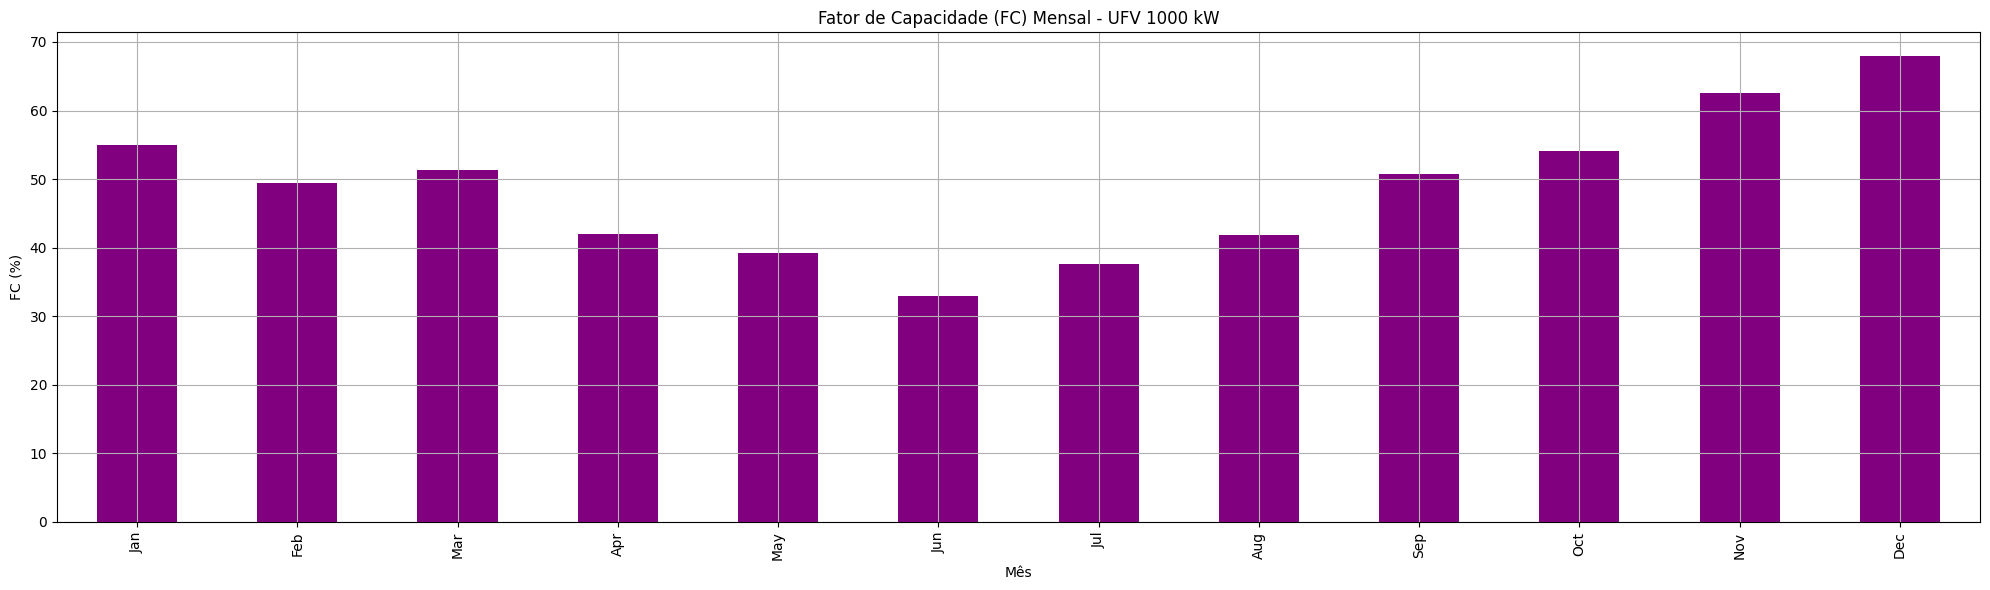

In [16]:
# Seção de Análise 5: Cálculo dos Indicadores de Desempenho (Yf, Yr, PR, FC)

# Calcula o desempenho da UFV com base nas energias geradas e irradiância

# Parâmetros do módulo para cálculo da potência nominal do gerador DC
vmp = module_params['V_mp_ref'] # Tensão no ponto de máxima potência (STC)
imp = module_params['I_mp_ref'] # Corrente no ponto de máxima potência (STC)
potencia_gerador_kW = (vmp * imp * n_modulos) / 1000  # Potência nominal do gerador DC em kW (kWp)

# POA mensal total (em kWh/m²)
# Sumariza a irradiância POA horária/minutal para obter a energia total em cada mês
poa_mensal_kWh_m2 = poa['poa_global'].resample('ME').sum() / 1000
poa_mensal_kWh_m2.index = poa_mensal_kWh_m2.index.strftime('%b') # Formata para nome do mês

# Yield Final (Yf): energia gerada AC / potência instalada (kWh/kWp)
# Indica a energia AC gerada por kWp instalado em um período.
Yf_mensal = energia_ac_mensal / potencia_gerador_kW

# Reference Yield (Yr): Irradiância POA em base kWh/kWp
# Indica a energia disponível (irradiância) por kWp de irradiância de referência (1 kW/m²) em um período.
Yr_mensal = poa_mensal_kWh_m2  # já está em kWh/m²; ao dividir por 1.0 kW/m², unidade vira kWh/kWp

# Performance Ratio (PR)
# É a razão entre o Yield Final e o Reference Yield, representando a eficiência geral do sistema após as perdas.
PR_mensal = (Yf_mensal / Yr_mensal) * 100 # Multiplica por 100 para obter em porcentagem

# Fator de Capacidade (FC)
# Indica a porcentagem da potência nominal que a usina gerou em média durante um período.
# (Energia Gerada AC Total no Período) / (Potência Nominal da Usina * Horas do Período)
# Considerando 30 dias por mês para simplificação
FC_mensal = (energia_ac_mensal / (P_Total * 24 * 30)) * 100

# --- Visualização dos Indicadores de Desempenho ---

# Plota o gráfico Yf mensal
Yf_mensal.plot(kind='bar',
               figsize=(20, 6),
               title='Yield Final (Yf) Mensal - UFV 1000 kW',
               ylabel='kWh/kWp',
               xlabel='Mês',
               color='orange',
               grid=True)
plt.tight_layout()
plt.show()

# Plota o gráfico Yr mensal
Yr_mensal.plot(kind='bar',
               figsize=(20, 6),
               title='Reference Yield (Yr) Mensal - POA Irradiance',
               ylabel='kWh/kWp',
               xlabel='Mês',
               color='deepskyblue',
               grid=True)
plt.tight_layout()
plt.show()

# Plota o gráfico PR mensal
PR_mensal.plot(kind='bar',
               figsize=(20, 6),
               title='Performance Ratio (PR) Mensal - UFV 1000 kW',
               ylabel='PR (%)',
               xlabel='Mês',
               color='green',
               grid=True)
plt.tight_layout()
plt.show()

# Plota o gráfico FC mensal
FC_mensal.plot(kind='bar',
               figsize=(20, 6),
               title='Fator de Capacidade (FC) Mensal - UFV 1000 kW',
               ylabel='FC (%)',
               xlabel='Mês',
               color='purple',
               grid=True)
plt.tight_layout()
plt.show()

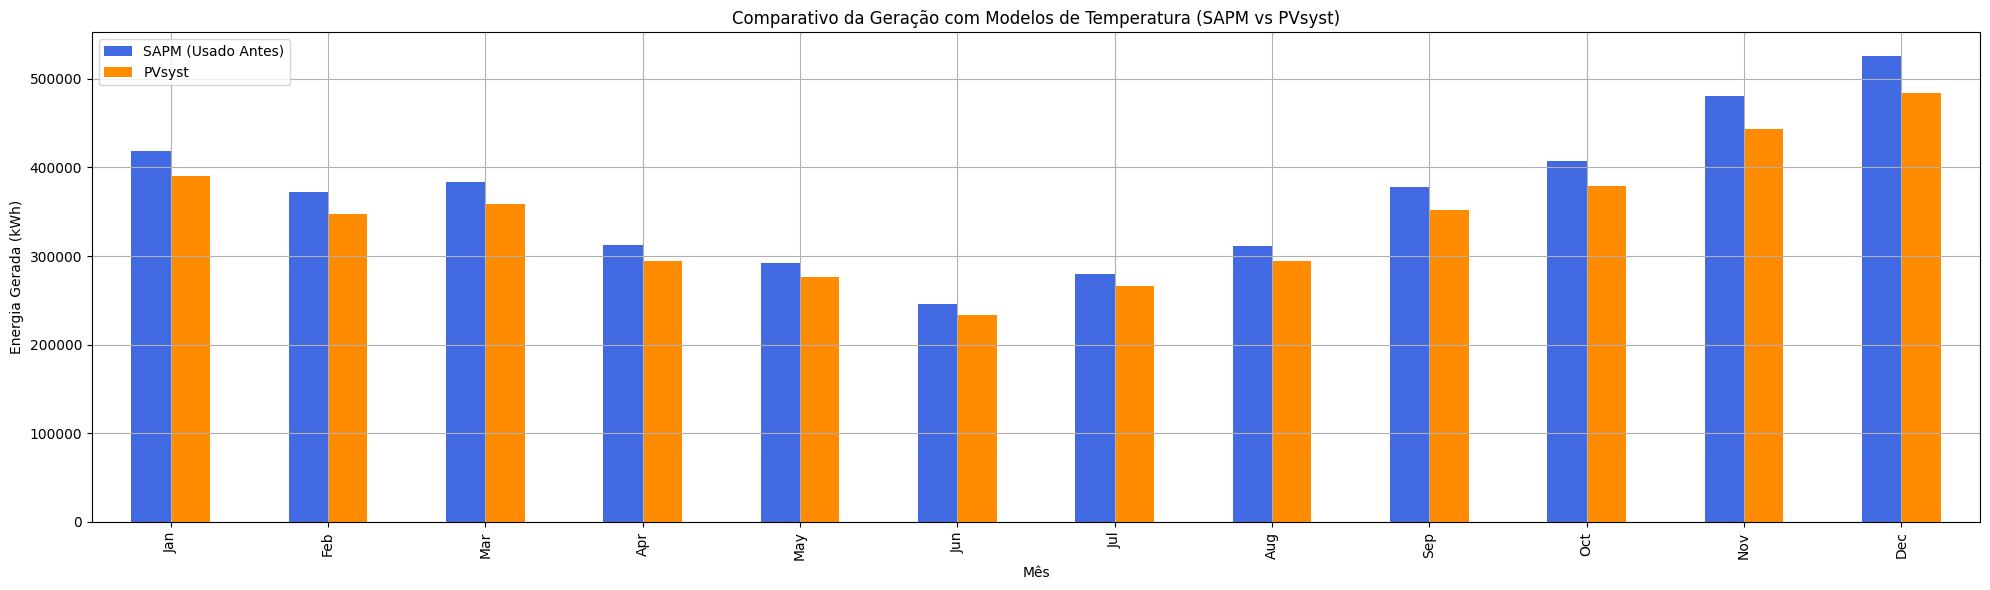


Perdas associadas à temperatura (SAPM vs PVsyst) - em kWh por mês:
timestamp
Jan    28263.658381
Feb    24859.814081
Mar    24882.726976
Apr    17634.980583
May    15183.789974
Jun    11667.408568
Jul    14013.557755
Aug    17521.432443
Sep    25573.965404
Oct    28280.386491
Nov    37235.096295
Dec    41713.720088
dtype: float64


In [17]:
# Seção de Análise 6: Comparativo de Modelos de Temperatura (SAPM vs PVsyst)

# 2. Modelagem da Usina Considerando Diferentes Modelos de Temperatura, no caso, foi escolhido o modelo PVSyst

from pvlib.temperature import sapm_cell, pvsyst_cell
from pvlib.pvsystem import calcparams_cec, singlediode

# Modelo SAPM (Sandia Array Performance Model) para cálculo da temperatura da célula PV
# Este modelo já foi utilizado implicitamente no cálculo DC anterior.
temp_sapm = sapm_cell(
    poa['poa_global'],       # Irradiância POA
    df_formatado['Temperature'], # Temperatura ambiente
    df_formatado['Wind Speed'],  # Velocidade do vento
    a=-3.47, # Coeficiente 'a' típico para montagem livre (open rack)
    b=-0.0594, # Coeficiente 'b' típico para montagem livre
    deltaT=3 # Diferença de temperatura entre a célula e o módulo
)

# Modelo PVsyst para cálculo da temperatura da célula PV
# Este modelo é amplamente utilizado e considera diferentes tipos de montagem.
temp_pvsyst = pvsyst_cell(
    poa['poa_global'],       # Irradiância POA
    df_formatado['Temperature'], # Temperatura ambiente
    df_formatado['Wind Speed'],  # Velocidade do vento
    u_c=29,  # Coeficiente de perda térmica com o ambiente (W/(m²*K)) - típico para montagem sobre telhado
    u_v=0    # Coeficiente de perda térmica com o vento (W*s/(m³*K)) - pode ser zero para simplificação ou usado com a velocidade do vento
)

# Recalcula os parâmetros do SDM (Single Diode Model) usando o MODELO CEC, mas agora com as temperaturas calculadas pelo modelo PVsyst
IL_pv, I0_pv, Rs_pv, Rsh_pv, nNsVth_pv = calcparams_cec(
    poa['poa_global'],   # Irradiância no plano dos módulos
    temp_pvsyst,         # Temperatura da célula calculada pelo modelo PVsyst
    module_params['alpha_sc'],
    module_params['a_ref'],
    module_params['I_L_ref'],
    module_params['I_o_ref'],
    module_params['R_sh_ref'],
    module_params['R_s'],
    module_params['Adjust']
)

# Resolve o modelo de diodo único com as novas temperaturas (do modelo PVsyst)
sdm_out_pvsyst = singlediode(IL_pv, I0_pv, Rs_pv, Rsh_pv, nNsVth_pv, method='lambertw')

# Calcula a potência DC total gerada com as temperaturas do modelo PVsyst
p_dc_pvsyst = sdm_out_pvsyst['p_mp'] * n_modulos

# Calcula a energia mensal DC com as temperaturas do modelo PVsyst
energia_pvsyst_mensal = p_dc_pvsyst.resample('ME').sum() / 1000
energia_pvsyst_mensal.index = energia_pvsyst_mensal.index.strftime('%b') # Formata para nome do mês

# Gráfico comparativo entre a energia gerada usando os dois modelos de temperatura (SAPM e PVsyst)
energia_comparativa_temp = pd.concat([energia_dc_mensal, energia_pvsyst_mensal], axis=1) # Concatena as séries
energia_comparativa_temp.columns = ['SAPM (Usado Antes)', 'PVsyst'] # Renomeia as colunas

energia_comparativa_temp.plot(kind='bar',
                               figsize=(20, 6),
                               title='Comparativo da Geração com Modelos de Temperatura (SAPM vs PVsyst)',
                               xlabel='Mês',
                               ylabel='Energia Gerada (kWh)',
                               color=['royalblue', 'darkorange'], # Cores para as barras
                               grid=True)
plt.tight_layout()
plt.show()

# Estimativa de perdas por temperatura entre os dois modelos de cálculo (SAPM vs PVsyst)
perdas_temp = (energia_comparativa_temp['SAPM (Usado Antes)'] - energia_comparativa_temp['PVsyst'])
print("\nPerdas associadas à temperatura (SAPM vs PVsyst) - em kWh por mês:")
print(perdas_temp)

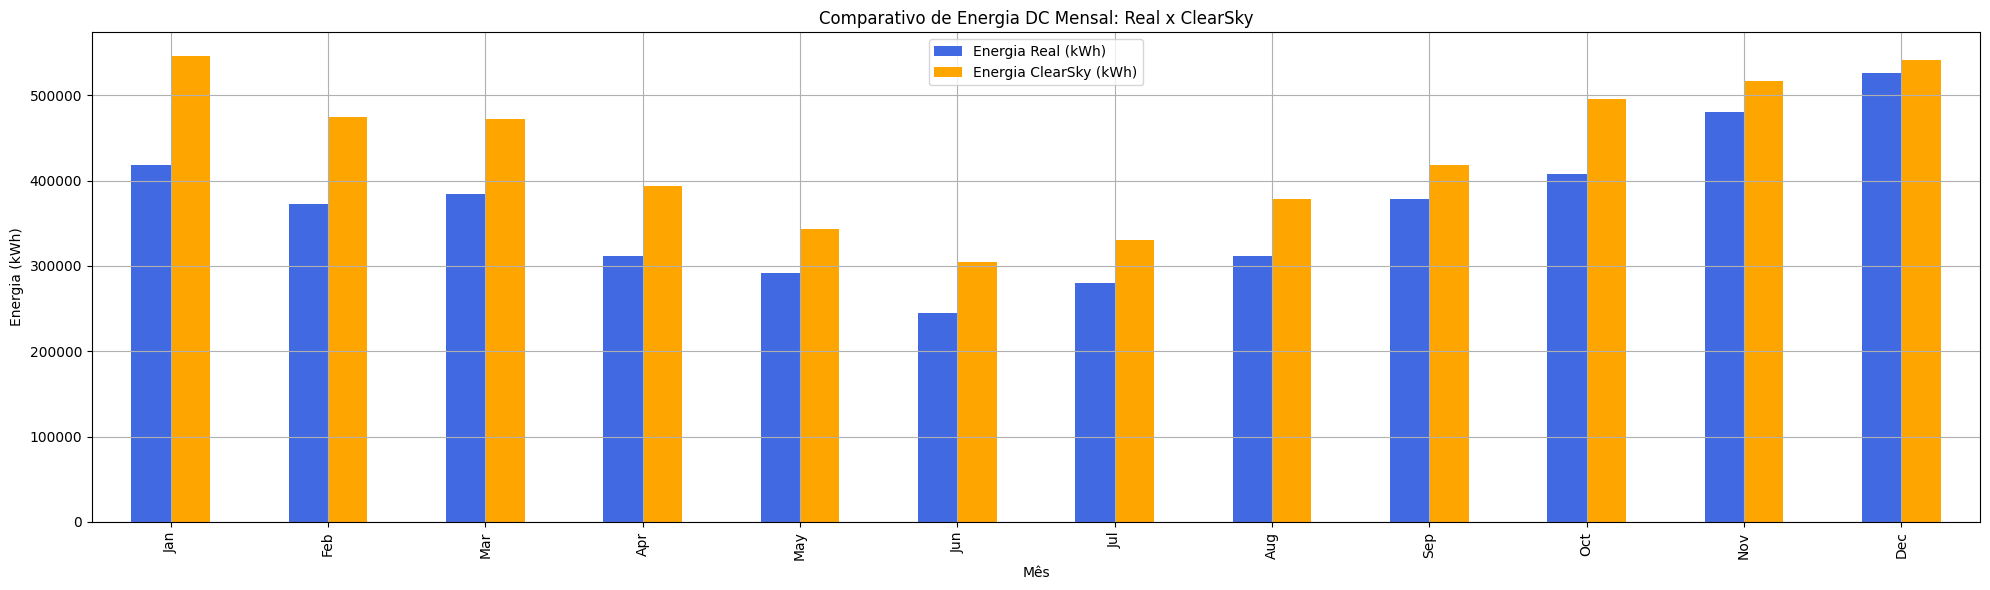


Energia real anual: 4408059.70 kWh
Energia com céu limpo anual: 5216423.57 kWh
Redução percentual total: 15.50%
Como pode ser observado, há uma diferença de 808.4 MWh em relação ao céu real.
Com o céu 100 porcento limpo é possível notar que, de fato, os fatores climáticos influênciam diretamente na geração fotovoltáica


In [18]:
# Seção de Análise 7: Comparativo de Geração (Real vs ClearSky)

from pvlib.temperature import sapm_cell
from pvlib.pvsystem import calcparams_cec, singlediode

# 3. Modelagem da Usina Considerando o Modelo ClearSky

# Nova simulação utilizando o método ClearSky para obter a irradiância esperada em condições de céu limpo
# O modelo 'ineichen' é utilizado para estimar a irradiância em condições de céu limpo.
clearsky = site.get_clearsky(df_formatado.index, model='ineichen')

# Calcula a temperatura da célula utilizando o modelo SAPM e a irradiância ClearSky
# Utilizamos as mesmas temperaturas medidas presentes no arquivo CSV para isolar o efeito da irradiância ClearSky na geração.
temp_clearsky = sapm_cell(
    clearsky['ghi'],         # Irradiância Global Horizontal ClearSky
    df_formatado['Temperature'], # Temperatura ambiente (do CSV)
    df_formatado['Wind Speed'],  # Velocidade do vento (do CSV)
    a=-3.47,
    b=-0.0594,
    deltaT=3
)

# Calcula os parâmetros do SDM para condições clearsky
# Usa a irradiância ClearSky e a temperatura calculada com base nela.
IL_c, I0_c, Rs_c, Rsh_c, nNsVth_c = calcparams_cec(
    clearsky['ghi'],     # Irradiância Global Horizontal ClearSky
    temp_clearsky,       # Temperatura da célula calculada com ClearSky
    module['alpha_sc'],
    module['a_ref'],
    module['I_L_ref'],
    module['I_o_ref'],
    module['R_sh_ref'],
    module['R_s'],
    module['Adjust']
)

# Resolve equação SDM novamente, mas usando os valores obtidos no ClearSky
sdm_clearsky = singlediode(IL_c, I0_c, Rs_c, Rsh_c, nNsVth_c)

# Calcula a potência DC total gerada em condições ClearSky
p_dc_clearsky_total = sdm_clearsky['p_mp'] * n_modulos

# Calcula a energia mensal DC em condições ClearSky
energia_dc_clearsky = p_dc_clearsky_total.resample('ME').sum() / 1000
energia_dc_clearsky.index = energia_dc_clearsky.index.strftime('%b') # Formata para nome do mês

# Comparação da energia DC mensal gerada em condições reais (do CSV) com a energia gerada no modelo ClearSky
energia_comparativa = pd.concat([energia_dc_mensal, energia_dc_clearsky], axis=1)
energia_comparativa.columns = ['Energia Real (kWh)', 'Energia ClearSky (kWh)'] # Renomeia as colunas

energia_comparativa.plot(kind='bar',
                         figsize=(20, 6),
                         title='Comparativo de Energia DC Mensal: Real x ClearSky',
                         xlabel='Mês',
                         ylabel='Energia (kWh)',
                         color=['royalblue', 'orange'], # Cores para as barras
                         grid=True)
plt.tight_layout()
plt.show()

# Cálculo e exibição da diferença e percentual de redução entre a energia ClearSky e a energia Real
diferenca_abs = energia_dc_clearsky - energia_dc_mensal # Diferença absoluta por mês
diferenca_percentual = ((energia_dc_clearsky - energia_dc_mensal) / energia_dc_clearsky) * 100 # Diferença percentual por mês

energia_real_total = energia_dc_mensal.sum() # Energia real total anual
energia_clearsky_total = energia_dc_clearsky.sum() # Energia ClearSky total anual
percentual_total = ((energia_clearsky_total - energia_real_total) / energia_clearsky_total) * 100 # Redução percentual total anual

print(f"\nEnergia real anual: {energia_real_total:.2f} kWh")
print(f"Energia com céu limpo anual: {energia_clearsky_total:.2f} kWh")
print(f"Redução percentual total: {percentual_total:.2f}%")
diferenca_total = (energia_clearsky_total - energia_real_total)/1000 # Diferença total em MWh
print(f"Como pode ser observado, há uma diferença de {diferenca_total:.1f} MWh em relação ao céu real.\nCom o céu 100 porcento limpo é possível notar que, de fato, os fatores climáticos influênciam diretamente na geração fotovoltáica")

Perda total estimada por clipping no ano: 4.46% (196624 kWh).
Clipping, teoricamente, é a perda de eficiência do inversor nos momentos em que a geração ultrapassa a capacidade projetada, o que limita a injeção de potência na REDE.
Esse fenômeno aumenta conforme o tamanho do oversizing da potência dos módulos.


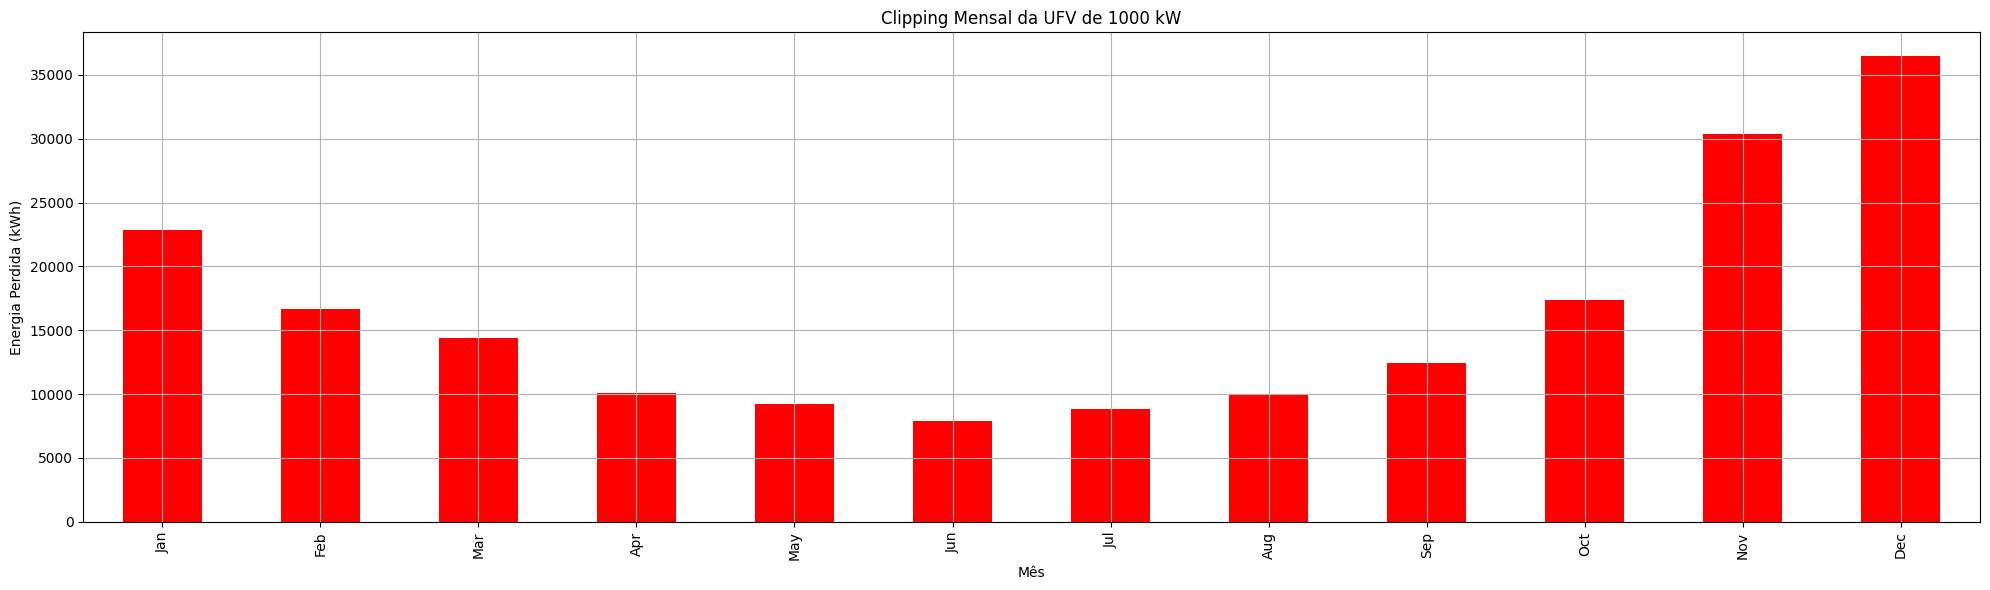

In [19]:
# Seção de Análise 8: Cálculo e Análise do Clipping do Inversor

# @title
# 4. Cálculo do Clipping do Inversor

# O clipping ocorre quando a potência DC gerada pelos módulos excede a potência máxima de entrada ou de saída do inversor.
# Calcula a energia "clipada" (perdida devido à limitação do inversor)
clipping = p_dc_total - pac_total # Diferença entre a potência DC gerada e a potência AC convertida
# O clipping será um valor positivo apenas nos momentos em que p_dc_total > pac_total (que já está limitado pelo inversor)

# Calcula a energia de clipping mensal (em kWh)
energia_clipping_mensal = clipping.resample('ME').sum() / 1000
energia_clipping_mensal.index = energia_clipping_mensal.index.strftime('%b') # Formata para nome do mês


# Cálcula o valor total anual do clipping e da energia DC total para calcular o percentual de perda por clipping
energia_clipping_total = clipping.sum() / 1000 # Energia clipada total anual em kWh
energia_dc_total = p_dc_total.sum() / 1000 # Energia DC total gerada anual em kWh

# Calcula o percentual de perda total por clipping no ano
percentual_clipping = (energia_clipping_total / energia_dc_total) * 100
print(f"Perda total estimada por clipping no ano: {percentual_clipping:.2f}% ({energia_clipping_total:.0f} kWh).")
print("Clipping, teoricamente, é a perda de eficiência do inversor nos momentos em que a geração ultrapassa a capacidade projetada, o que limita a injeção de potência na REDE.")
print("Esse fenômeno aumenta conforme o tamanho do oversizing da potência dos módulos.")

# Plota o gráfico de barras do clipping mensal
energia_clipping_mensal.plot(kind='bar',
                             figsize=(20, 6),
                             title='Clipping Mensal da UFV de 1000 kW',
                             ylabel='Energia Perdida (kWh)',
                             xlabel='Mês',
                             color='red', # Cor vermelha para as perdas
                             grid=True)
plt.tight_layout()
plt.show()